<a href="https://colab.research.google.com/github/razvanratoi/Energy-Management-System/blob/main/full_dataset_may.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install concrete-ml

In [1]:
import pandas as pd
import numpy as np
from joblib import load, dump
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_df = pd.read_csv(f'{folder_path}/updated_train.csv')
test_df = pd.read_csv(f'{folder_path}/updated_test.csv')

In [3]:
features = ['POD', 'DayOfWeek', 'HourOfDay', 'Month',
       'Day', 'Lag1_TotalActiveEnergy', 'Week_of_Year', 'Quarter', 'Year',
        'Lag2_TotalActiveEnergy', 'Lag3_TotalActiveEnergy',
       'RollingMean_3H', 'RollingStd_3H', 'RollingMean_6H', 'RollingStd_6H',
       'RollingMean_12H', 'RollingStd_12H', 'HourOfDay_sin', 'HourOfDay_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'HourDay_Interaction',
       'CumulativeEnergy']

targets = ['TotalActiveEnergy']

df = pd.concat([train_df, test_df])

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X_train = train_df[features]
y_train = train_df[targets]
X_test = test_df[features]
y_test = test_df[targets]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from concrete.ml.sklearn.xgb import XGBRegressor

xgb = XGBRegressor(n_estimators=200)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(n_bits={'op_inputs': 6, 'op_leaves': 6}, n_estimators=200)

In [7]:
xgb.compile(X_test_scaled[:1000])
y_pred = xgb.predict(X_test_scaled[:10000], fhe='simulate')
mse = mean_squared_error(y_test[:10000], y_pred)
r2 = r2_score(y_test[:10000], y_pred)

In [8]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 78.94772514420299
R^2 Score: 0.9398072629719891


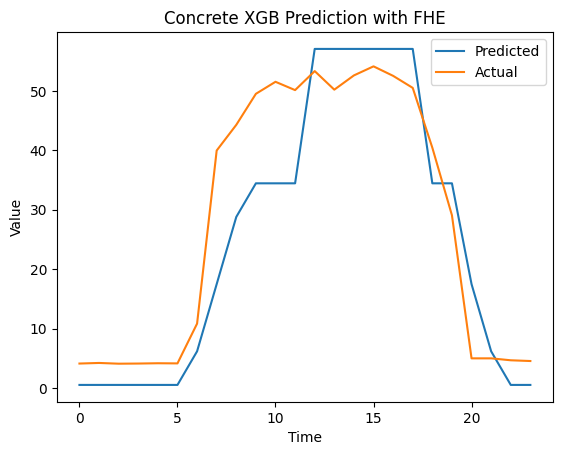

In [10]:
plt.plot(y_pred[:24], label='Predicted')
plt.plot(y_test[:24], label='Actual')

plt.title('Concrete XGB Prediction with FHE')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend()

plt.show()

In [16]:
from concrete.ml.deployment import FHEModelDev
from tempfile import TemporaryDirectory
from shutil import copyfile
import os

dev_dir = TemporaryDirectory()
dev = FHEModelDev(dev_dir.name, xgb)
dev.save()

dev_dir_path = f'{folder_path}/latest_model'
os.makedirs(dev_dir_path, exist_ok=True)

copyfile(dev_dir.name + '/client.zip', f'{dev_dir_path}/client.zip')
copyfile(dev_dir.name + '/server.zip', f'{dev_dir_path}/server.zip')

'/content/drive/My Drive/datasets/latest_model/server.zip'

In [17]:
dump(scaler, f'{dev_dir_path}/scaler.pkl')

['/content/drive/My Drive/datasets/latest_model/scaler.pkl']

In [18]:
train_df.to_csv(f'{folder_path}/history.csv', index=False)

In [19]:
features.append('TotalActiveEnergy')
history = train_df[features]
history.to_csv(f'{folder_path}/history.csv', index=False)